In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

#Some code to beautify the plots
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

### Load test problem

Text(0.5,1,'With noise')

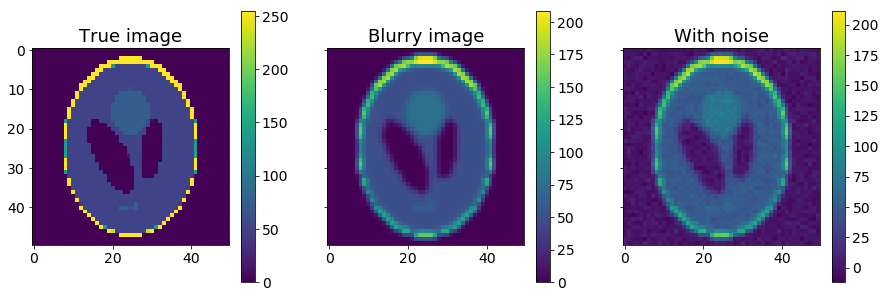

In [2]:
from testproblems import blur
n = 50
A, b, xtrue = blur(n, band = 10, sigma = 0.7, phant = 'shepp')


# add noise
noise = 0.02*np.linalg.norm(b, np.inf)*np.random.randn(b.size) 
bn = b + noise

f, (ax1,ax2,ax3) = plt.subplots(1,3, sharey = True, figsize = (15,5))
cax1 = ax1.imshow(xtrue.reshape(n,n))
ax1.set_title('True image', fontsize = 18)
f.colorbar(cax1, ax = ax1)
cax2 = ax2.imshow(b.reshape(n,n))
f.colorbar(cax2, ax = ax2)
ax2.set_title('Blurry image', fontsize = 18)
cax3 = ax3.imshow(bn.reshape(n,n))
f.colorbar(cax3, ax = ax3)
ax3.set_title('With noise', fontsize = 18)

### Method 0: Tikhonov regularization

The error in the reconstruction is 0.9418073562923021
The error in the reconstruction is 0.6795085144611459
The error in the reconstruction is 0.3764635699514114
The error in the reconstruction is 0.2810902616080918
The error in the reconstruction is 0.44153737128350407
The error in the reconstruction is 0.5450826272782308


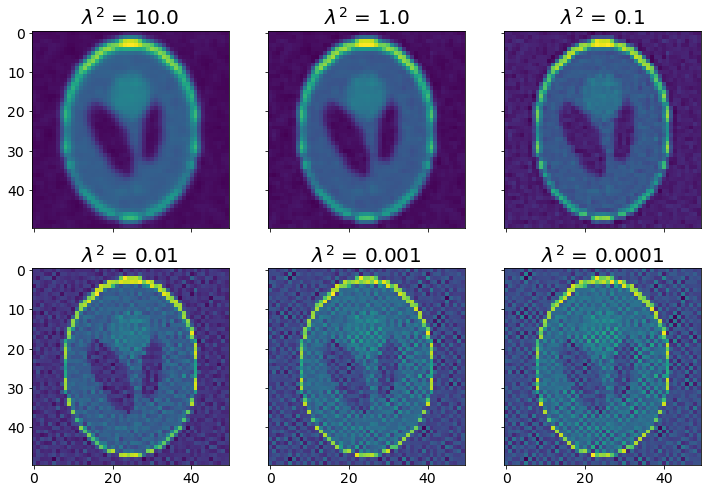

In [3]:
l2lst = [1e1,1e0,1e-1,1e-2,1e-3,1e-4]

from scipy.sparse.linalg import aslinearoperator, LinearOperator, cg
Aop = aslinearoperator(A)

Atb = Aop.rmatvec(bn)
f, axarray = plt.subplots(2,3, sharex = True, sharey = True, figsize = (12,8))
for i, ax in enumerate(axarray.flatten()):
    l2 = l2lst[i]
    
    mat = lambda x: Aop.rmatvec(Aop.matvec(x)) + l2*x
    H   = LinearOperator(shape = A.shape, matvec = mat)
    
    xk, info = cg(H, Atb, tol = 1.e-7)
    
    err_ = np.linalg.norm(xk-xtrue)/np.linalg.norm(xtrue)
    print "The error in the reconstruction is", err_
    
    ax.imshow( xk.reshape(n,n))
    ax.set_title('$\lambda^2$ = ' + str(l2), fontsize = 20)

## Method 1: Gradient based regularization

In [4]:
from scipy.sparse import eye, kron, diags
I = eye(n, format = "csr")

data = np.ones((2,n), dtype ='d')
data[0,:] *= -1.0

D = diags(data, np.array([-1,0]), shape=(n+1,n))
L = kron(I,D) + kron(D,I)
Lop = aslinearoperator(L)

Text(0.5,1.05,'Sparsity of L')

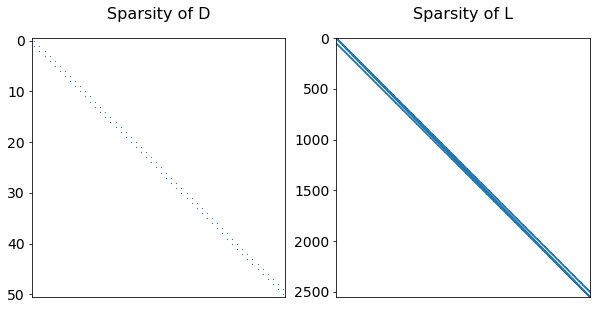

In [5]:
f, (ax1, ax2) = plt.subplots(1,2)
ax1.spy(D, markersize = 0.3)
ax1.set_xticks([])
ax1.set_title('Sparsity of D', fontsize = 16)
ax2.spy(L, markersize = 0.3)
ax2.set_xticks([])
ax2.set_title('Sparsity of L', fontsize = 16)

The error in the reconstruction is 0.6918522745546979
The error in the reconstruction is 0.5801713280823177
The error in the reconstruction is 0.4486115590440417
The error in the reconstruction is 0.3283858384195056
The error in the reconstruction is 0.3182264603706446
The error in the reconstruction is 0.465807415393066


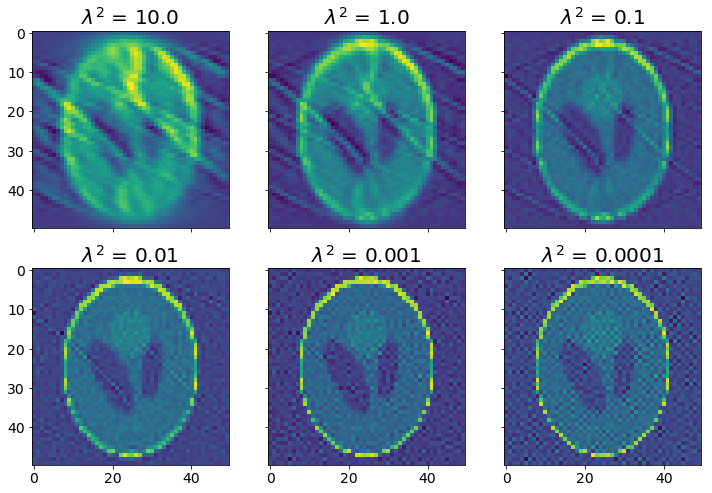

In [6]:
l2lst = [1e1,1e0,1e-1,1e-2,1e-3,1e-4]


Atb = Aop.matvec(bn)
f, axarray = plt.subplots(2,3, sharex = True, sharey = True, figsize = (12,8))
for i, ax in enumerate(axarray.flatten()):
    l2 = l2lst[i]
    
    
    mat = lambda x: Aop.rmatvec(Aop.matvec(x)) + l2*Lop.rmatvec(Lop.matvec(x))
    H   = LinearOperator(shape = A.shape, matvec = mat)
    
    xk, info = cg(H, Atb, tol = 1.e-7)
    
    err_ = np.linalg.norm(xk-xtrue)/np.linalg.norm(xtrue)
    print "The error in the reconstruction is", err_
    
    ax.imshow( xk.reshape(n,n))
    ax.set_title('$\lambda^2$ = ' + str(l2), fontsize = 20)

## Method 2: Total Variation regularization

In [7]:
def tvreg(Aop, Lop, b, l2, maxiter = 100, eps = 1.e-3):
    
    np1 = Lop.shape[0]
    
    xk = np.zeros((Aop.shape[1],), dtype = 'd')
    for k in range(maxiter):
        Lx = Lop.matvec(xk)
        dk = 0.5/np.sqrt(Lx**2. + eps)
        Dk = diags(dk[:,np.newaxis].T, [0], shape = (np1,np1))
        Dk = aslinearoperator(Dk)
        
        # Construct the rhs 
        rk = Aop.matvec(xk)-b
        gk = Aop.rmatvec(rk) + l2*Lop.rmatvec(Dk.matvec(Lx))
        
        # Construct the Hessian operator
        mat = lambda x: Aop.rmatvec(Aop.matvec(x)) + l2*Lop.rmatvec(Dk.matvec(Lop.matvec(x)))
        H  = LinearOperator(shape = Aop.shape, matvec = mat)
    
        # Gauss-Newton update
        pk, info = cg(H, gk, maxiter = 100, tol = 1.e-5)
        xk -= pk
        stepsize = np.linalg.norm(pk)/np.linalg.norm(xk + eps)
        if stepsize < 1.e-3:
            break
            
    return xk, k+1

Number of iterations 46 , error is  0.6421304040600382
Number of iterations 36 , error is  0.45061111719964925
Number of iterations 24 , error is  0.22387576668510606
Number of iterations 21 , error is  0.306359981293866
Number of iterations 10 , error is  0.5102690766584228
Number of iterations 6 , error is  0.5581885415382666


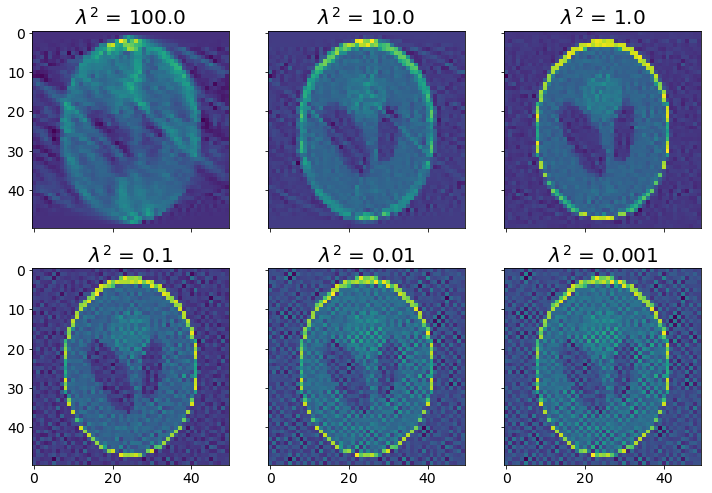

In [8]:
l2lst = [1e2,1e1,1e0,1e-1,1e-2,1e-3]
err = []
f, axarray = plt.subplots(2,3, sharex = True, sharey = True, figsize = (12,8))
for i, ax in enumerate(axarray.flatten()):
    l2 = l2lst[i]
    xk, iters = tvreg(Aop, Lop, bn, l2)
    err_ = np.linalg.norm(xk-xtrue)/np.linalg.norm(xtrue)
    err.append(err_)
    print "Number of iterations", iters, ", error is ", err_
    
    ax.imshow( xk.reshape(n,n))
    ax.set_title('$\lambda^2$ = ' + str(l2), fontsize = 20)